# Lesson 6

## Tabular -> Rossman

### Time Series Aproach

Most of the time the state of the art results don't use recurrent networks but rather feed fordwar networks and instead what they do is just add a lot of meta data regarding the date:

    add_datepart(train, "Date", drop=False)
    add_datepart(test, "Date", drop=False)
This metadata includes end of week, month, year, sales, etc.

### Data preparation:

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *

In [3]:
path = Config().data_path()/'rossmann'
train_df = pd.read_pickle(path/'train_clean')

In [4]:
train_df.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,5,2015-07-31,5263,555,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,7.0,0.0,5.0
1,1,2,5,2015-07-31,6064,625,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,2,3,5,2015-07-31,8314,821,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
3,3,4,5,2015-07-31,13995,1498,1,1,False,1,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,4,5,5,2015-07-31,4822,559,1,1,False,1,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0


In [5]:
n = len(train_df)
n

844338

### Experimenting with sample

First thing we will look at is something called **preprocesses** which is kind of similar to transforms however transforms are bits of code that run every time something is grabbed from a dataset and so it's really good for data augmentation. Preprocesses are like transforms but instead run only once before we start training.

Something important to note is that they run once in our training set and then any kind of state or metadata created is then shared with the validation and test set.

To start experimenting let's create a smaller dataset to play around with.

In [6]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[:1000]]

small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars = ['Store', 'DayOfWeek', 'PromoInterval']

small_train_df = small_train_df[small_cat_vars +small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [7]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
301,303,5,"Feb,May,Aug,Nov",15430.0,61,9026
718,720,5,"Feb,May,Aug,Nov",15320.0,61,11260
1590,479,4,"Feb,May,Aug,Nov",320.0,51,14465
1776,665,4,"Jan,Apr,Jul,Oct",90.0,56,9400
1961,850,4,"Jan,Apr,Jul,Oct",1120.0,73,6081


As we can see from above PromoInterval is sometimes missing, we have to preprocess that using categorify.

When we look our dataset we will see the exact same stuff but what categorify does is store internally a number for each category but externally is showing strings. 

In [8]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

Let's look at how our categories are stored:

In [9]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [10]:
small_train_df.PromoInterval.cat.codes[:5]

301     0
718     0
1590    0
1776    1
1961    1
dtype: int8

Well, the numbers above just represent each category, as we know this will end up in an embedding matrix, however we can't look up '-1' in it so we just add 1 to everything.

Another useful pre-processing is **FillMissing** which creates for everything missing a column with a 1 if such value is missing and 0 otherwise. For continious variables it will replace the NAN with the median of such values.

In [11]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test = True)

In [12]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
214147,291,6,NaN,2140.0,91,5553,True
306673,622,2,NaN,2140.0,69,3480,True
338488,622,4,NaN,2140.0,58,5024,True


### Preparing Full Data Set

It's key to know that using fastai we don't have to manually call pre-processes, when we call **TabularList** we can pass it a list of preprocesses.

In [13]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [14]:
len(train_df), len(test_df)

(844338, 41088)

In [15]:
procs=[FillMissing, Categorify, Normalize]

It's important to tell our data which are categorical and which are continious variables since this means the difference of creating an embedding or not.

In [16]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [17]:
deep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [deep_var, 'Date']].copy()

In [18]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [19]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()

In [20]:
valid_idx = range(cut)

In [21]:
df[deep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

It's important to note that we have to tell fastai in the following line:
     
     .label_from_df(cols=deep_var, label_cls=FloatList, log=True)
That our label (dependent variable) is a float so that fastai knows which activation function and loss function use at the output layer.

Also it's important to see that in the same line we have **log = True** which means that means we will be taking the log of our y and this is because of the evaluation metric used in by kaggle : RMSPE for this particular situation.

In [22]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
       .split_by_idx(valid_idx)
       .label_from_df(cols=deep_var, label_cls=FloatList, log=True)
       .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
       .databunch())

### Model and regularization: regular dropout, embedding dropur and batchnorm

In [23]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device = defaults.device)

Here there are several important things to note:

- **y_range** is the variable that will help our sigmoid determine which will be the range of values to pursue while making our predictions.
- **layers** this is the *architecture* for our tabular model (simple feedforward network). One important thing to note here is that the intermediate weight matrix will be of size 1000 by 500 whick is equal to 500k elements in such weigth matrix which is a lot for a dataset with a few 100k rows so we will find ourselves probably *overfitting* and the way to ensure it doesn't is using regularization, one way to do that is to use **weight decay** which fastai already uses by default, however in this case we want a bit more regularization so we will use 2 other techiques as well: **ps** and **emb_drop** which both will provide dorpout.

What dropout does is that we throw away randomly some percentage of the activation (aka the nodes) in a feedforward network as shown in the picture:

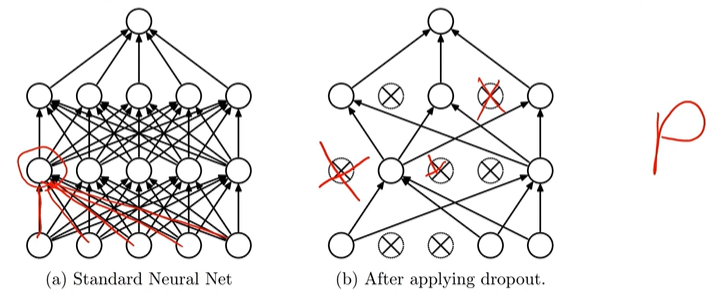

For each minibatch we throw away a different subset of activations, how many? well we throw away each of them with a probability **p**. A common value of this is 0.5. In the picture we can see inputs being deleted but that's not normal, usually we only drop hidden nodes. This works since we are prunning our model and making our activations unable to memorize some part of the input which is basically what overfitting is. Dropout will make this very hard. Too much dropout will increase the probability of underfitting since we are reducing the capacity of our model so we have to play around with the dropout a bit to get it on a correct value for each of our layers. This is where our parameter **ps** comes from, this is the dropout for our layers.

Now, there's an interesting thing happening at dropout and that is that it's divided in 2 stages:

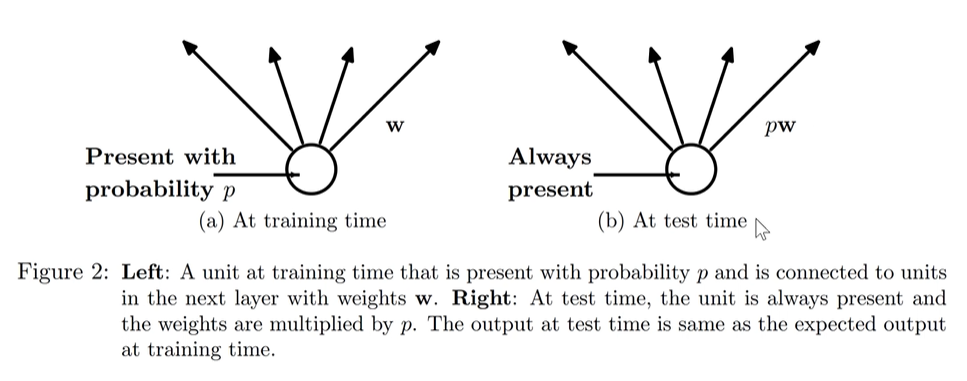

- training: This stage works as we just saw.

- testing: Here we obvoiusly turn off dropout beacause we want it to be as accurate as bossible but what this means is that if *p* was previously .5 then half of our activations where being removed which means that when they are all there, now our overall activation level is twice what it used to be therefore the best practice is multypling all our weights at test time by the probability of such activation being present *(1-p)*. What pytorch does instead is multiplying the weigths at training time by 1/(1-p) to account for the missing weigths instead of modifying them at test time.

The other important parameter to talk about is **emb_dropout** which is the dropout for our embedding layer. What happens is that this is the same as regular dropout but now it drops some activations for the embeddings, this means we have the vector representative of a feature then we will drop some of the values of such representative vector inside our embedding.

In [39]:
learn  = tabular_learner(data, layers=[1000, 500], ps=[0.001, 0.01], emb_drop=0.04, y_range=y_range, metrics=exp_rmspe)

In [40]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [26]:
len(data.train_ds.cont_names)

16

Let's now talk about **batch nomralization** which as we can see is part from the layer in our networks.


Batch normalization is kind of a bit of regularization and training helper. Batchnorm helps us increase our learning rate. Wha thappens is that the algorithm will take a mini batch (group of activations). So first thing is we find the mean of the activations, then we find the variance of them and finally we normalize: *(xi - mean) / stddev*. However the really important bit is that we take those values, add a vector of biases (as usual) but then we will use another 'bias' term but rather than adding it, we will multiply it. This is a *multiplicative bias layer*. But, how this gives good results?

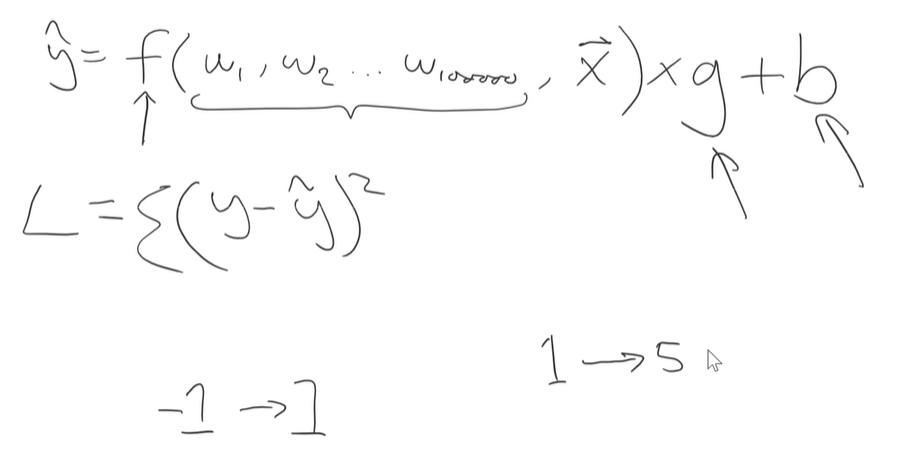


As we can see in the image above, what's basically happening is that lets say our fucntion should map to values between 1 and 5. However our function is throwing results between -1 and 1 so they are way off where they need to be, the scale is off, the mean is off. What can we do?

- Come up with a new set of weights that satisfy this condition but this is very hard to do since all this weights interact in intricate ways, there are all this nonlinearities and they are all combined together. 

- Multiply it by a scalar and add it a bias? Well we have a *g* which has a direct gradient of the scale of our function and *b* has a direct gradient to increase the mean. This is what batch norm does, it makes it easier for our model to shit the outputs.

Now there's something also important which is momentum:



This is not momentum as the one used in optimization but rather as in *exponentially weighted moving average*, specifically when calculating the mean and standard deviation used for our batch normalizations we actually don't use a different mean and std deviation for every minibatch (if we did it will vary so much that it will be very hard to train) so instead we use an *exponentially weighted moving average* of the mean and std deviation. We can vary the momentum in a batchnorm layer, the smaller the number the less the mean and std dev will vary from minibatch to minibatch and that will have less of a regularization effect, however a higher one will be the opposite and will have more of a regularization effect.

In [54]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


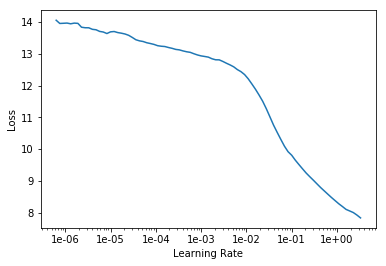

In [55]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time


In [ ]:
learn.save('1')

In [ ]:
learn.recorder.plot_losses(last=-1)

In [ ]:
learn.load('1')

In [ ]:
learn.fit_one_cycle(10, 3e-4)

## Vision -> Pets, Data Augmentation, Convolutions

Cool thing about data augmentation is that there's pretty much no cost to it. We can do it and get better generalization without it taking longer to train and without underfitting to an extent.

### Initial Configuration and Data

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

In [3]:
bs = 64

In [4]:
path = untar_data(URLs.PETS)/'images'

### Data augmentation

What do all the transforms mean?

- do_flip: if True, a random flip is applied with probability 0.5
- flip_vert: requires do_flip=True. If True, the image can be flipped vertically or rotated by 90 degrees, otherwise only an horizontal flip is applied
- max_rotate: if not None, a random rotation between -max_rotate and max_rotate degrees is applied with probability p_affine
- max_zoom: if not 1. or less, a random zoom between 1. and max_zoom is applied with probability p_affine
- max_lighting: if not None, a random lightning and contrast change controlled by max_lighting is applied with probability p_lighting
- max_warp: if not None, a random symmetric warp of magnitude between -max_warp and maw_warp is applied with probability p_affine
- p_affine: the probability that each affine transform and symmetric warp is applied
- p_lighting: the probability that each lighting transform is applied
- xtra_tfms: a list of additional transforms you would like to be applied

In [5]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4, p_affine=1., p_lighting=1.)

In [23]:
src =  ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [7]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [25]:
data = get_data(224, bs, 'zeros')

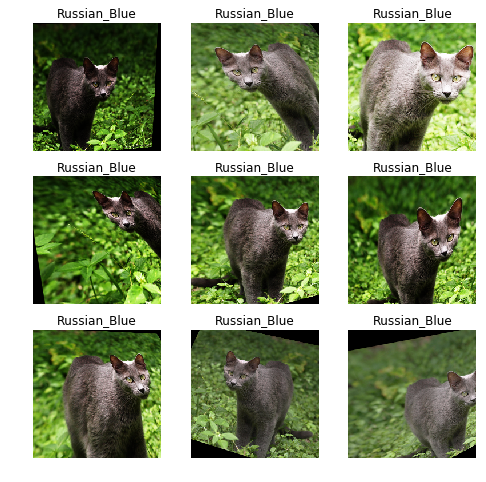

In [9]:
def _plot(i, j, ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)
plot_multi(_plot, 3, 3, figsize=(8, 8))

So we can see why this is going to work very well, all this images look very different but still real, it's almost like free extra data.

### Training Model

In [10]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [11]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 205520896 bytes. Error code 12 (Cannot allocate memory)


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-3), pct_start=0.8)

In [ ]:
data = get_data(352, bs)
learn.data = data

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

In [ ]:
learn.save('352')

### Convolutional NN

Let's try to figure out what's happening inside our cnn, the way we will do it is by creating a heatmap from a picture. This heatmap will show us what part of the image did the cnn was focusing on when it was trying to decide what such picture was.

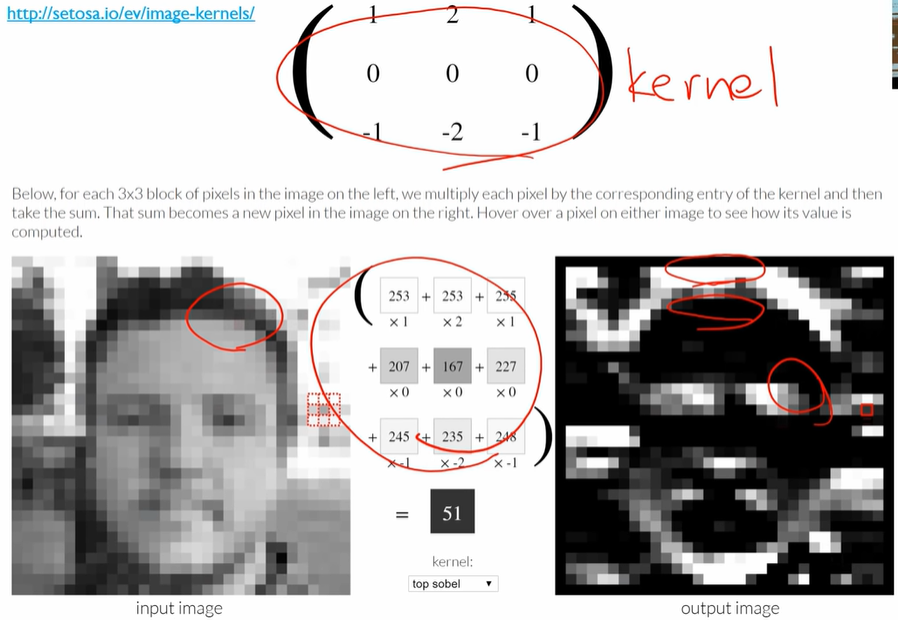

So let's take a look at the picture above. What we are doing is basically moving the **kernel** matrix to every spot in the image and then doing the dot product of that and the overlapping pixels. This will result in the image of the right where, effectively, we've identified places of horizontal white-black lines. As we may notice the output (**chanel**) is in the center of the square. This is called a **convoultion**. Now the nice thing gets interesting since we can combine a chanel that found top edges and one that found left edges and then the result of that will find top left corners.


A cool way of seeing it as well:
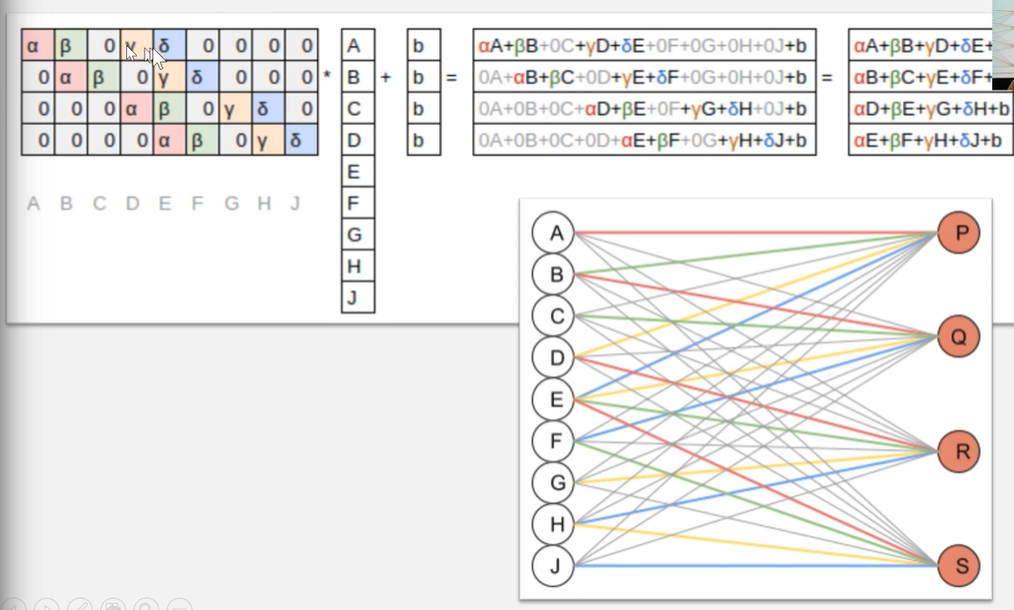

Now another thing is the padding of the picture, if we just do this convolution we will end up with an image with 1 pixel less on each side. So what we do is instead add a **padding** so that we end up with an image of the same size.

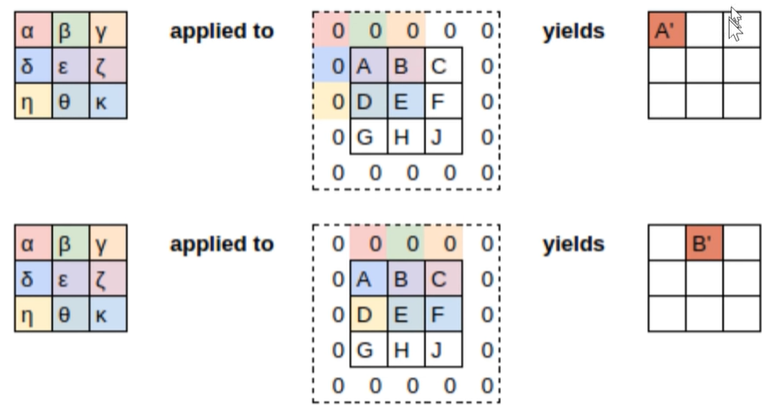

Now what happens if we want to do the same thing but to an RGB image, this is, not a rank 2 tensor as in the above example, but rather a **rank 3 tensor**. So we propably dont want to use the same kernel values for the 3 colors, for instance if we are trying to find a green frog then we would like higher activation values on the green color or if we are trying to find a gradient from green to blue then using a single kernel won't work. So we need to create a **rank 3 kernel**. However the dot product still gives us a sinlge number resulting in a **rank 2 kernel**, our input came from 3 chanels to 1 chanel. With one chanel we won't be able to do much, we just found a top edge but how are we going to find a side edge or a gradient or an area of constant white? well we have to create another kernel. If we do this several times and we stack them together we will get a **rank 3 tensor again**.

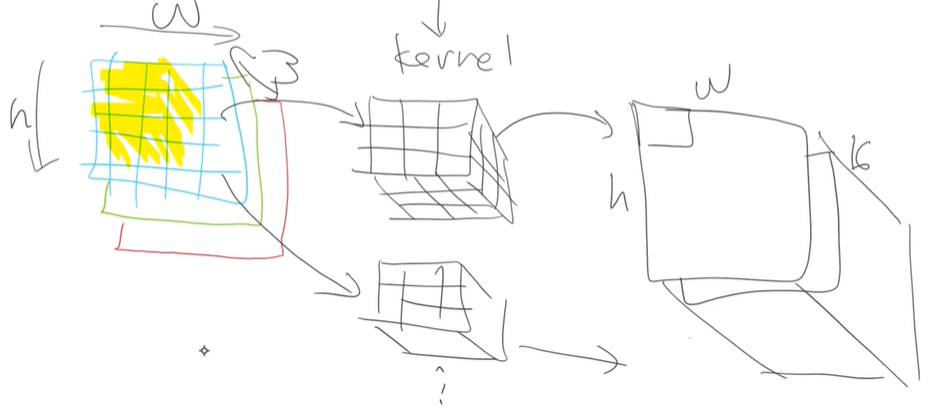

An interesting thing to note is that as we get deeper in the network we would like to have more chanels since we want to be able to identify more features,. however this will imply using a lot of memory if we don't change the size of the chanels (w x h). So what we do is to add sometimes a convolution layer that instead of steping the kernel one at a time it does it 2 at a time for instance. This is called a **stride 2** convolution. which will be (1/4 * w * h).

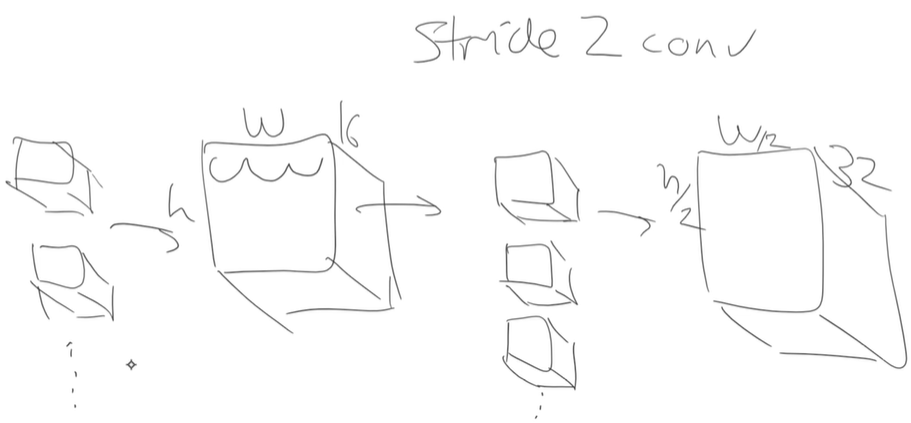

In [32]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True) #.load('352')

Lets do our own convolution.

Category Sphynx

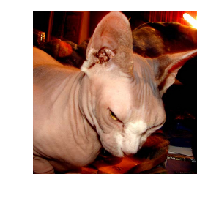

In [27]:
idx=0
x, y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [28]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

So basically what we are doing above is using this kernel expanding this rank 2 tensor to a rank 3 tensor by simply copying the same 3 times as the second parameter suggests. The reason for this is that we want to treat rgb the same way. The 1 in the beggining is the number of rank 3 tensors we have. This is the common practice and is thw way all the rank 3 tensors are stored in the convolution layers; this means we end up having a rank 4 tensor.

In [36]:
k.shape

torch.Size([1, 3, 3, 3])

In [37]:
t = data.valid_ds[0][0].data
t.shape

torch.Size([3, 224, 224])

As we can see above we will be using the first image from our validation dataset. However he **conv2d** method is designed to work on a minibatch so we use this t[None] trick which adds 1 axis at the begining of our tensor which is the number of images in our minibatch, in this case: 1.

In [38]:
t[None].shape

torch.Size([1, 3, 224, 224])

In [39]:
edge = F.conv2d(t[None], k)

Lets see how our convolution looks like:

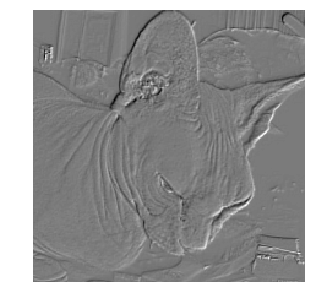

In [41]:
show_image(edge[0], figsize=(5, 5))

If we go learn.summary, remembering our input is 352 by 352 pixels, generally speaking the very first convolution has a stride 2, so after the first layer is 176 x 176 and the first set of convolutions has 64 activations (chanels). And then we cna see, as the layers advance we double the number of chanels twice. We end up with 512 chanels 11 by 11.

In [34]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

In [35]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Heat Map

Now, how do we get a heatmap?

Well we'll need a bit of introduction on how our last layers work.

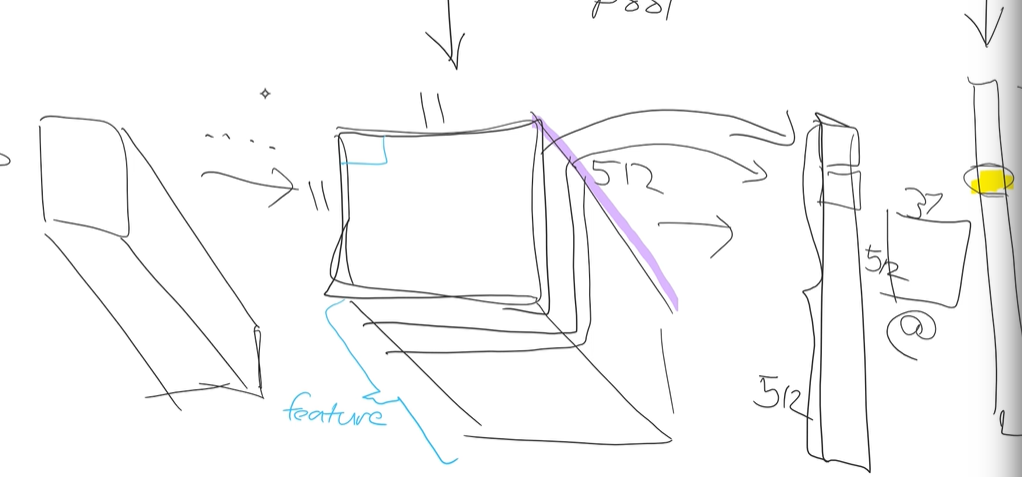

As we can see in the image above, our last convolution results in 512 11 by 11 chanels, so what we do is make a 512 sized vector with the mean of the values in all the chanels and then we pass those values as activations to our output layer and that's it. The step where we take the average of each chanel is called **average pooling**. Now as we should notice, each of the 512 values in the vector must represent features such as fluffyness, length of legs, nose color, etc. this since our final result is to have a high value at a certain position of our output vector which is a linear combinatino of all the 512 features.


So with this in mind what should have happened in our convolution layers is that by our last layer every part of it they should have come up with, for every chanel, for every single (row, column) part of it, how much whas such part a certain feature and such as fluffyness, and that this follows for all the last 11 by 11 chanel. So every chanel represents a different feature. So what we want to know for our heatmap is not what is the average of every chanel but rather what is the average of the value in each (row, column) out of the 512 chanels; such average basically represents how activated was that exact area, when it came to figureing out how that this was this type of animal, how many signs of this animal was on each of this areas. this is how our heatmap is created.

m = learn.model.eval()

We make our image into xb which is a minibatch with one thing in it.

In [ ]:
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
from fastai.callbacks.hooks import *

Now it's important to get our activations and we get them from a **hook**. A hook is basically a really cool, more advanced pytorch feature which lets' us hook into the pytorch machinery and run any arbitrary python code we want. What pytorch does is to only give us the output from our output layer however if we want somethign from a hidden layer that's where we use the hooks. In this case we want the output from the convolutional part of the model which, according to resnet34 architecture, it's the first part of the model : **m[0]**.


So what we do is hook the output from this model m[0] part using *hook_output* from fastai so what we have to do to evaluate the current image from it is to do a *forward pass* from our image. Now we don't really care about the predictions but rather about the hook we created.


Something to note is that when we create a hook in pytoch that means every single time we run that model we are storing those outputs so we have to remove it when we are stop using it otherwise it will get slow and memory intensive. So fastai provides a *with* as a context manager for hooks.

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a, hooh_g

In [ ]:
hook_a, hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()
acts.shape()

We get the average activations which are the average across the actual but in the 0th axis as we mentioned before, resulting in a shape of 11 by 11.

In [ ]:
avg_acts = act.mean(0)
avg_acts.shape

The show heatmap function receives our heatmap, plots the image then shows the heatmap with a 0.6 transparency, it extends it to a 352 by 352 image, it uses linear interpolation so that it doesn't look all blocky and the cmap will simply be magma.

In [ ]:
def show_heatmap(hm):
    _, ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent = (0, 352, 352, 0), interpolation='billinear', cmap='magma')

let's now see the heatmap:

In [ ]:
show_heatmap(acg_acts)